# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Получение данных из файла и изучение общей информации

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from functools import reduce

Прочитаем каждую таблицу файла и сохраним ее в отдельную переменную.

In [ ]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [ ]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [ ]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [ ]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [ ]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [ ]:
for df in [df_calls, df_internet, df_messages, df_tariffs, df_users]:
    print(df.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.fram

### Вывод

- Необходимо заменить тип данных для столбцов, содержащих дату, в каждой таблице, в которой они присутствуют, с object на datetime
   - столбец call_date в df_calls
   - столбец session_date в df_internet
   - столбец message_date в df_messages
   - столбец churn_date и reg_date в df_users
- Есть NaN в столбце churn_date у 38 пользователей из 500, значит у них еще действует выбранный ими тариф. Пропуски в этом столбце оставим как есть.
- В таблице df_calls длительность некоторой части звонков равна 0, в таблице df_internet объем интернет-трафика тоже где-то равен 0, нужно подсчитать количество таких значений, а также округлить все нецелые значения длительности в большую сторону, так как «Мегалайн» всегда округляет вверх значения минут и мегабайтов.

## Подготовка данных

### Замена типа данных

In [ ]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format = '%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')

### Замена нулевых значений

Подсчитаем количество нулевых строк в столбцах duration в df_calls и mb_used в df_internet, а также округлим все значения в большую сторону.

In [ ]:
df_calls['duration'] = np.ceil(df_calls['duration'])
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])

In [ ]:
(len(df_internet[df_internet['mb_used'] == 0]) / len(df_internet))*100

13.118155773916303

In [ ]:
(len(df_calls[df_calls['duration'] == 0]) / len(df_calls))*100

19.551644316336553

Процент нулей достаточно большой в обеих таблицах -  13% и 20% соответственно. Округлять эти значения в сторону единицы кажется нелогичным, так как скорее всего, "нулевые" звонки - это пропущенные звонки, а "нулевой" объем интернет-трафика - это случаи подключения к интернету, но отсутствие обмена какой-либо информацией. Исключим эти строки из таблиц, так как они не расходуют лимиты тарифы и не формируют выручку.

In [ ]:
df_calls['duration'] = df_calls['duration'].replace(0, np.NaN)
df_calls.dropna(subset = ['duration'], inplace = True)

df_internet['mb_used'] = df_internet['mb_used'].replace(0, np.NaN)
df_internet.dropna(subset = ['mb_used'], inplace = True)

In [ ]:
for df in [df_calls, df_internet]:
    print(df.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 4 columns):
id           162994 non-null object
call_date    162994 non-null datetime64[ns]
duration     162994 non-null float64
user_id      162994 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      129798 non-null int64
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null datetime64[ns]
user_id         129798 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.9+ MB
None



### Расчёты и добавление результатов в таблицу

#### Расчёт значения количества звонков, длительности звонков, количества сообщений и объема интернет-трафика за месяц для каждого пользователя

Определим месяц для каждого расчетного значения.

In [ ]:
df_calls['month'] = df_calls['call_date'].values.astype('datetime64[M]')
df_messages['month'] = df_messages['message_date'].values.astype('datetime64[M]')
df_internet['month'] = df_internet['session_date'].values.astype('datetime64[M]')

Сгруппируем данные для каждого расчетного значения по user_id и месяцу и сохраним в отдельную таблицу.

In [ ]:
df_calls_count = df_calls.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()
df_calls_count.columns = ['user_id','month','calls_count']
df_calls_count.head(15)

,user_id,month,calls_count
0,1000,2018-05-01,17
1,1000,2018-06-01,28
2,1000,2018-07-01,41
3,1000,2018-08-01,42
4,1000,2018-09-01,46
5,1000,2018-10-01,44
6,1000,2018-11-01,37
7,1000,2018-12-01,38
8,1001,2018-11-01,45
9,1001,2018-12-01,47


In [ ]:
df_calls_duration = df_calls.groupby(['user_id','month'])[['duration']].agg(['sum']).reset_index()
df_calls_duration.columns = ['user_id','month','calls_duration']
df_calls_duration.head()

,user_id,month,calls_duration
0,1000,2018-05-01,159.0
1,1000,2018-06-01,172.0
2,1000,2018-07-01,340.0
3,1000,2018-08-01,408.0
4,1000,2018-09-01,466.0


In [ ]:
df_messages_count = df_messages.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()
df_messages_count.columns = ['user_id','month','messages_count']
df_messages_count.head()

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


In [ ]:
df_internet_mb_used = df_internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()
df_internet_mb_used.columns = ['user_id','month','mb_used_month']
df_internet_mb_used.head()

,user_id,month,mb_used_month
0,1000,2018-05-01,2256.0
1,1000,2018-06-01,23257.0
2,1000,2018-07-01,14016.0
3,1000,2018-08-01,14070.0
4,1000,2018-09-01,14581.0


 #### Объединение таблиц

Определим для каждого пользователя месяц подключения тарифа.

In [ ]:
df_users['reg_month'] = df_users['reg_date'].values.astype('datetime64[M]')

Определим временной промежуток: от самого раннего месяца подключения рассматриваемых тарифов у пользователей до самого позднего.

In [ ]:
df_users['reg_month'].min()

Timestamp('2018-01-01 00:00:00')

In [ ]:
df_users['reg_month'].max()

Timestamp('2018-12-01 00:00:00')

Создадим таблицу, где для каждого пользователя будет каждый месяц этого временного промежутка.

In [ ]:
df_time_period = pd.DataFrame(pd.date_range(df_users['reg_month'].min(),df_users['reg_month'].max(),freq='MS'))
df_time_period.columns = ['month']
df_time_period

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [ ]:
df_time_period['key'] = 1
df_users['key'] = 1
report = df_time_period.merge(df_users,on='key')
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,2018-01-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
1,2018-01-01,1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,2018-01-01,1,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-01
3,2018-01-01,1,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-01
4,2018-01-01,1,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-01


Для пользователей, которые подключили тарифы после минимального месяца временного промежутка, уберем ненужные строчки.

In [ ]:
report = report[report['month']>=report['reg_month']].sort_values(by=['user_id', 'month'], ascending=True)
report.head()

,month,key,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
2000,2018-05-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
2500,2018-06-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
3000,2018-07-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
3500,2018-08-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01
4000,2018-09-01,1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01


Объединим все таблицы в одну.

In [ ]:
report = report.merge(df_calls_count,how='left',on=['user_id', 'month'])

In [ ]:
report = report.merge(df_calls_duration,how='left',on=['user_id', 'month'])

In [ ]:
report = report.merge(df_messages_count,how='left',on=['user_id', 'month'])

In [ ]:
report = report.merge(df_internet_mb_used,how='left',on=['user_id', 'month'])

Оставим в таблице только столбцы, необходимые для дальнейшего анализа.

In [ ]:
cols = ['age', 'churn_date', 'first_name', 'last_name', 'reg_date', 'reg_month']
report.drop(cols, inplace=True, axis=1)
report.head(15)

,month,key,user_id,city,tariff,calls_count,calls_duration,messages_count,mb_used_month
0,2018-05-01,1,1000,Краснодар,ultra,17.0,159.0,22.0,2256.0
1,2018-06-01,1,1000,Краснодар,ultra,28.0,172.0,60.0,23257.0
2,2018-07-01,1,1000,Краснодар,ultra,41.0,340.0,75.0,14016.0
3,2018-08-01,1,1000,Краснодар,ultra,42.0,408.0,81.0,14070.0
4,2018-09-01,1,1000,Краснодар,ultra,46.0,466.0,57.0,14581.0
5,2018-10-01,1,1000,Краснодар,ultra,44.0,350.0,73.0,14717.0
6,2018-11-01,1,1000,Краснодар,ultra,37.0,338.0,58.0,14768.0
7,2018-12-01,1,1000,Краснодар,ultra,38.0,333.0,70.0,9827.0
8,2018-11-01,1,1001,Москва,smart,45.0,430.0,NaN,18452.0
9,2018-12-01,1,1001,Москва,smart,47.0,414.0,NaN,14053.0


Посмотрим на пропуски и заменим найденные на 0.

In [ ]:
report.isnull().sum().sort_values()

month               0
key                 0
user_id             0
city                0
tariff              0
mb_used_month      58
calls_count        91
calls_duration     91
messages_count    542
dtype: int64

In [ ]:
for col in ['calls_duration','mb_used_month', 'calls_count', 'messages_count']:
    report[col] = report[col].fillna(0)

In [ ]:
report.isnull().sum().sort_values()

month             0
key               0
user_id           0
city              0
tariff            0
calls_count       0
calls_duration    0
messages_count    0
mb_used_month     0
dtype: int64

 <div style="background: #FFA07A;color: #fff;padding: 10px;border-radius: 5px">Перед расчетом месячной выручки для каждого пользователя посмотрим, присутствуют ли в выборке пользователи, которые совсем не пользуются сотовой связью. Заказчик не предоставлял нам такую информацию, но вероятнее всего, в таком случае абонентская плата взиматься не будет. Избавимся от этих строк, так как для анализа, целью которого является определение более прибыльного тарифа, они не представляют ценности.</div>

In [ ]:
len(report)

3259

In [ ]:
report[(report['calls_duration'] == 0) & (report['messages_count'] == 0)& (report['mb_used_month'] == 0)]

,month,key,user_id,city,tariff,calls_count,calls_duration,messages_count,mb_used_month
142,2018-11-01,1,1019,Томск,ultra,0.0,0.0,0.0,0.0
143,2018-12-01,1,1019,Томск,ultra,0.0,0.0,0.0,0.0
224,2018-12-01,1,1034,Вологда,smart,0.0,0.0,0.0,0.0
318,2018-11-01,1,1050,Тюмень,ultra,0.0,0.0,0.0,0.0
319,2018-12-01,1,1050,Тюмень,ultra,0.0,0.0,0.0,0.0
326,2018-11-01,1,1051,Москва,smart,0.0,0.0,0.0,0.0
327,2018-12-01,1,1051,Москва,smart,0.0,0.0,0.0,0.0
367,2018-11-01,1,1056,Иркутск,smart,0.0,0.0,0.0,0.0
368,2018-12-01,1,1056,Иркутск,smart,0.0,0.0,0.0,0.0
466,2018-09-01,1,1071,Омск,smart,0.0,0.0,0.0,0.0


In [ ]:
len(report) - len(report[(report['calls_duration'] == 0) & (report['messages_count'] == 0)& (report['mb_used_month'] == 0)])

3214

In [ ]:
report.drop(report[(report['calls_duration'] == 0) & (report['messages_count'] == 0)& (report['mb_used_month'] == 0)].index, inplace=True)

In [ ]:
len(report)

3214

#### Расчёт помесячной выручки для каждого пользователя.

In [ ]:
def revenue_sum(row):
    calls_duration = row['calls_count']
    messages_count = row['messages_count']
    mb_used_month = row['mb_used_month']
    tariff = row['tariff']
    
    if tariff == 'ultra':
        extra_messages = messages_count - df_tariffs.loc[1, 'messages_included']
        extra_mb = mb_used_month - df_tariffs.loc[1, 'mb_per_month_included']
        extra_minutes = calls_duration - df_tariffs.loc[1, 'minutes_included']
        
        if extra_messages < 0:
            extra_messages = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_minutes < 0:
            extra_minutes = 0
            
        return(
            extra_messages * df_tariffs.loc[1, 'rub_per_message'] + extra_mb*(df_tariffs.loc[1, 'rub_per_gb'] / 1024) +
            extra_minutes * df_tariffs.loc[1, 'rub_per_minute'] + df_tariffs.loc[1, 'rub_monthly_fee']
              )
    else:
        extra_messages = messages_count - df_tariffs.loc[0, 'messages_included']
        extra_mb = mb_used_month - df_tariffs.loc[0, 'mb_per_month_included']
        extra_minutes = calls_duration - df_tariffs.loc[0, 'minutes_included']
        
        if extra_messages < 0:
            extra_messages = 0
        if extra_mb < 0:
            extra_mb = 0
        if extra_minutes < 0:
            extra_minutes = 0
            
        return(
            extra_messages * df_tariffs.loc[0, 'rub_per_message'] + extra_mb*(df_tariffs.loc[0, 'rub_per_gb'] / 1024) +
            extra_minutes * df_tariffs.loc[0, 'rub_per_minute'] + df_tariffs.loc[0, 'rub_monthly_fee']
              )
            
        
    


    
report['month_revenue'] = report.apply(revenue_sum, axis=1)
report.head(15)

,month,key,user_id,city,tariff,calls_count,calls_duration,messages_count,mb_used_month,month_revenue
0,2018-05-01,1,1000,Краснодар,ultra,17.0,159.0,22.0,2256.0,1950.000000
1,2018-06-01,1,1000,Краснодар,ultra,28.0,172.0,60.0,23257.0,1950.000000
2,2018-07-01,1,1000,Краснодар,ultra,41.0,340.0,75.0,14016.0,1950.000000
3,2018-08-01,1,1000,Краснодар,ultra,42.0,408.0,81.0,14070.0,1950.000000
4,2018-09-01,1,1000,Краснодар,ultra,46.0,466.0,57.0,14581.0,1950.000000
5,2018-10-01,1,1000,Краснодар,ultra,44.0,350.0,73.0,14717.0,1950.000000
6,2018-11-01,1,1000,Краснодар,ultra,37.0,338.0,58.0,14768.0,1950.000000
7,2018-12-01,1,1000,Краснодар,ultra,38.0,333.0,70.0,9827.0,1950.000000
8,2018-11-01,1,1001,Москва,smart,45.0,430.0,0.0,18452.0,1153.906250
9,2018-12-01,1,1001,Москва,smart,47.0,414.0,0.0,14053.0,550.000000


### Вывод

Данные были приведены к нужным типам.<br>Для каждого пользователя были рассчитаны значения количества звонков, длительности звонков, количества сообщений и объема интернет-трафика за месяц и объединены в одну таблицу.<br>Для каждого пользователя также были рассчитана помесячная выручка.

## Анализ данных

Для каждого из тарифов посчитаем среднее, медиану, дисперсию и стандартное отклонение расчетных значений.

In [ ]:
report_stat = report.pivot_table(index = ['tariff'],
                                  values = ['calls_duration', 'messages_count', 'mb_used_month', 'month_revenue'],
                                  aggfunc = {'calls_duration': [np.mean, np.median, np.var, np.std],
                                             'messages_count': [np.mean, np.median, np.var, np.std],
                                             'mb_used_month': [np.mean, np.median, np.var, np.std],
                                             'month_revenue': [np.mean, np.median, np.var, np.std]})
report_stat

calls_duration                                   mb_used_month  \
                 mean median         std            var          mean   
tariff                                                                  
smart      417.934948  422.0  190.313730   36219.315784  16229.188425   
ultra      526.623350  518.0  317.606098  100873.633397  19486.901523   

                                            messages_count                    \
         median           std           var           mean median        std   
tariff                                                                         
smart   16531.0   5877.576978  3.454591e+07      33.384029   28.0  28.227876   
ultra   19324.0  10096.317202  1.019356e+08      49.363452   38.0  47.804457   

                    month_revenue                                          
                var          mean       median         std            var  
tariff                                                                     
smart    796.812958   1108.532508   796.726562  707.933508  501169.852273  
ultra   2285.266143   2060.529971  1950.000000  356.305046  126953.285460

- Длительность звонков в месяц: <br>Медиана длительности звонков у пользователей обоих тарифов в месяц примерно одинакова, однако дисперсия и стандартное отклонение у пользователей тарифа "Ультра" больше, то есть значения более разнообразны относительно среднего.<br><br>
- Объем интернет-трафика в месяц: <br>Пользователи тарифа "Ультра" в среднем расходут больше мегабайт интернет-трафика, чем пользователи тарифа "Смарт", опять же дисперсия и стандартное отклонение у пользователей тарифа "Ультра" больше, разброс значений больше.<br><br>
- Количество отправленных сообщений в месяц: <br>Медиана отправленных сообщений в месяц у пользователей тарифа "Ультра" смещена в большую сторону по сравнению с медианой у пользователей тарифа "Смарт", как и у других расчетных значений дисперсия и стандартное отклонение у пользователей тарифа "Ультра" больше<br><br>
- Месячная выручка: <br>Здесь все отличается. Медианная выручка у пользователей тарифа "Ультра" больше, чем медианная выручка пользователей тарифа "Смарт", и равна ежемесячной плате по тарифу. Медианная выручка пользователей тарифа "Смарт" больше, чем ежемесячная плата по тарифу примерно на 250 рублей, при этом дисперсия и стандартное отклонение у пользователей тарифа "Смарт" в этом случае больше. Предположительно пользователи тарифа "Смарт" чаще переплачиват по тарифу, чем те, кто пользуется "Ультра"<br>

In [ ]:
def my_hist(col):
    
    if col == 'calls_duration':
        title = 'Длительность звонков в месяц, мин.'
    elif col == 'mb_used_month':
        title = 'Объём потраченного за месяц интернет-трафика, Мб.'
    else:
        title = 'Количество отправленных сообщений в месяц, шт.'
    
    
        
    filtered_smart_data = report[(report['tariff'] == 'smart')][col]
    filtered_ultra_data = report[(report['tariff'] == 'ultra')][col]
    
    #Избавимся от выбросов, оставим только нормальные значений
    for df in [filtered_smart_data, filtered_ultra_data]:
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)
        iqr = q3 - q1
        df = df[(df >= (q1 - 1.5*iqr)) & (df <= (q3 + 1.5*iqr))]

    
        
    filtered_smart_data.plot(kind='hist', bins= 30, figsize=(12,6), ec='black', color='#87CEEB', title = title)
    filtered_ultra_data.plot(kind='hist', bins = 40, figsize=(12,6), ec='black', color='#90EE90', title = title, alpha = 0.8)
    
    plt.axvline(x=filtered_smart_data.median(),linewidth=3, color='#87CEEB', linestyle='--')
    plt.axvline(x=filtered_ultra_data.median(),linewidth=3, color='#90EE90', linestyle='--')
    
    plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12})
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.grid()
    plt.show()

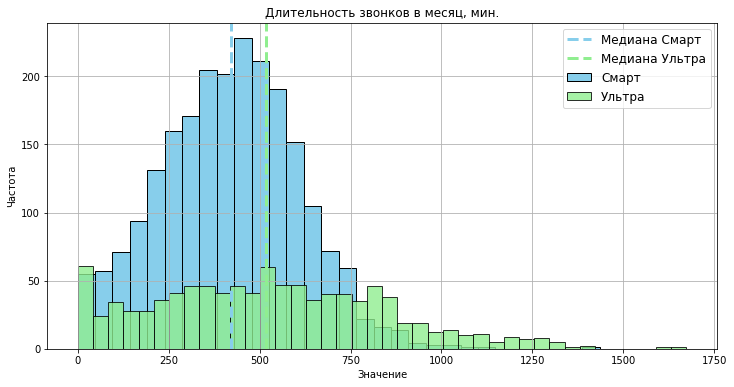

In [ ]:
my_hist('calls_duration')

Большинство пользователей тарифа «Смарт» в месяц тратят от 200 до 750 минут разговора. Медиана равна 422 минутам, что очень близко к лимиту минут разговора в месяц (500 минут) <br> Распределение - нормальное.<br><br>
У пользователй тарифа "Ультра" поведение более разнообразное, чем у тех, кто пользуется тарифом «Смарт»: много пользователей, кто вообще практически не разговаривает по телефону (пик у 0 минут), но при этом практически столько же пользователей тратят в месяц и 200 минут, и 400 минут и 700.<br>Распределение - нормальное.

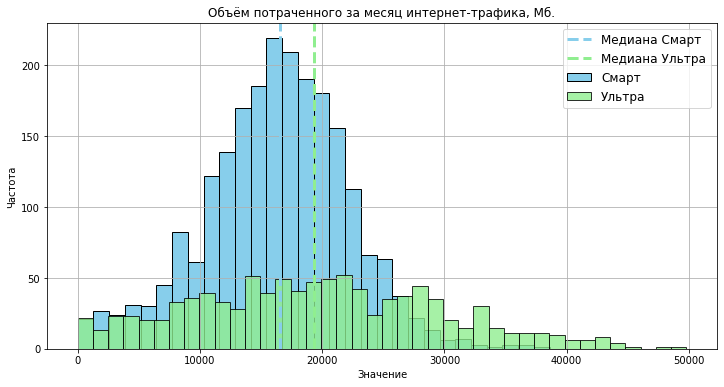

In [ ]:
my_hist('mb_used_month')

In [ ]:
15*1024

15360

In [ ]:
30*1024

30720

Пользователи тарифа «Смарт» в среднем в месяц используют от 10 до 20 Гб интернет-трафика. Медиана равна 16 Гб, что больше, чем установленный тарифом лимит. Больше, чем половине пользователей тарифа «Смарт» не хватает лимита интернет-трафика и они дозаказывают дополнительные пакеты интернет-трафика. <br> Распределение - нормальное.<br><br>
У пользователей тарифа "Ультра" разброс значений использованного трафика гораздо шире. Однако, лимит интернет-трафика у них гораздо больше, вследствие этого очень малое количество пользователей пользуются дополнительными пакетами.<br>Распределение - нормальное.

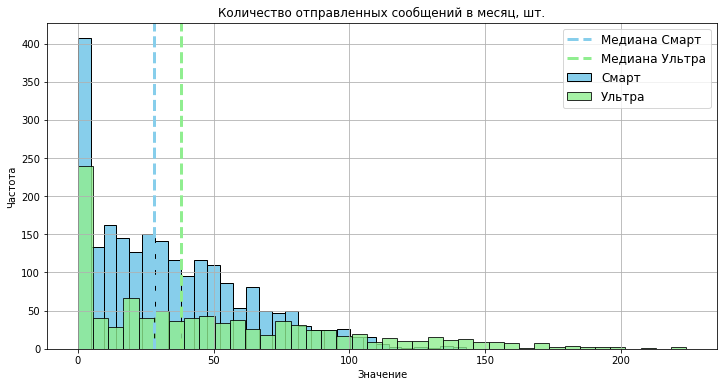

In [ ]:
my_hist('messages_count')

Пользователи обоих тарифов схожи по своему поведению - большинство не отправляет сообщения.<br>
Пользователи тарифа «Смарт», кто отправляет сообщения, отправляют до 100 сообщений в месяц. Учитывая то, что лимит по тарифу установлен в 50 сообщений, есть группа пользователей, превышающая лимит. Опять же поведение пользователей тарифа "Ультра" более разнообразно, есть такие, кто отправляет и по 175 сообщений в месяц и по 25.
<br>Распределение - нормальное со смещением влево.

### Вывод

Проанализиров таблицу статистических показателей и гистограммы расчетных значений, отметим, что:
- Пользователи обоих тарифов практически не отправляют СМС-сообщения.
- Больше, чем половине пользователей тарифа «Смарт» не хватает лимита интернет-трафика и они дозаказывают дополнительные пакеты интернет-трафика. У пользователей тарифа "Ультра" разброс значений использованного трафика гораздо шире. Однако, лимит интернет-трафика у них больше, вследствие этого очень малое количество пользователей пользуются дополнительными пакетами трафика сверх тарифного пакета.
- Пользователи тарифа "Смарт" в большинстве случаев переходят границу установленого тарифом лимита минут разговора: больше половины значений минут разговора либо очень близко к лимиту, либо его превышает. У пользователей тарифа "Ультра" поведение более разнообразное, чем у тех, кто пользуется тарифом «Смарт»: много пользователей, кто вообще практически не разговаривает по телефону (пик у 0 минут), но при этом практически столько же пользователей тратят в месяц и 200 минут, и 400 минут и 700 минут.

## Проверка гипотез

### Гипотеза 1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Нулевая гипотеза:  Средние выручки пользователей тарифов «Ультра» и «Смарт» равны. <br>
Альтернативная гипотеза: Средние выручки пользователей тарифов «Ультра» и «Смарт» различаются.

In [ ]:
ultra = report[(report['tariff'] == 'ultra')]['month_revenue']
smart = report[(report['tariff'] == 'smart')]['month_revenue']

alpha = .05

results = st.ttest_ind(ultra, smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.5930187141643347e-284
Отвергаем нулевую гипотезу


In [ ]:
tariff_month_revenue_stat = report.pivot_table(index = ['tariff'],
                                  values = ['month_revenue'],
                                  aggfunc = {'month_revenue': ['count', 'mean', 'median']})
tariff_month_revenue_stat

month_revenue                          
               count         mean       median
tariff                                        
smart           2229  1108.532508   796.726562
ultra            985  2060.529971  1950.000000

 <div style="background: #FFA07A;color: #fff;padding: 10px;border-radius: 5px"></div><br>Нулевая гипотеза отвергнута. Сводная таблица подтверждает альтернативную гипотезу, что средние выручки совсем не равны. Средние значения ежемесячной выручки по тарифам различаются практически в 2,5 раза.<br>
 Пользователи тарифа "Ультра" в среднем приносят большую выручку, так как ежемесячная плата в 3,5 раза больше ежемесячной платы пользователей тарифа "Смарт". Пользователи тарифа "Смарт" в среднем переплачивают на 250 рублей в месяц, но все равно не приносят такой доход.

### Гипотеза 2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза:  Cредняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. <br>
Альтернативная гипотеза: Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [ ]:
moscow = report[(report['city'] == 'Москва')]['month_revenue']
len(moscow)

611

In [ ]:
n_moscow = report[(report['city'] != 'Москва')]['month_revenue']
len(n_moscow)

2603

In [ ]:
alpha = .05

results = st.ttest_ind(moscow, n_moscow)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.24506493275719932
Не получилось отвергнуть нулевую гипотезу


In [ ]:
moscow.mean()

1432.5026212152209

In [ ]:
n_moscow.mean()

1392.7321862694487

In [ ]:
moscow.mean() - n_moscow.mean()

39.770434945772195

Нулевую гипотезу отвергнуть не получилось. Средняя выручка в Москве и в регионах действительно практически не отличается: в Москве переплачивают всего лишь 40 рублей.

### Вывод

В результате проведнных статистических тестов определили:
- доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 796 рублей соответственно.
- доходы в Москве и регионах не отличаются

## Общий вывод

По результатам анализа делаем вывод, что выручка от тарифа «Ультра» больше, чем от тарифа «Смарт»: за одного пользователя тарифа «Ультра» компания получает 1950 рублей в месяц, а за одного пользователя тарифа «Смарт» - 797 рублей в месяц.

- Пользователям бюджетного тарифа «Смарт» не хватает услуг в рамках тарифного пакета, а конкретно минут разговора и объема интернет-трафика: ежемесячная доплата в среднем составляет 250 рублей.
- Доходы от тарифов не зависят от географического фактора: в Москве и в регионах практически не различаются.
- Пользователи тарифа «Ультра», платят 3,5 раза больше, но не используют возможности тарифа в полном объеме.